# Analyse Complète du Réseau de Transport DOTNET

## Objectifs d'apprentissage
À la fin de cette session pratique, vous serez capable de :
- Charger et manipuler des réseaux de transport avec NetworkX et GeoPandas
- Analyser les données GMNS (General Modeling Network Specification)
- Visualiser les réseaux de transport géographiquement
- Comprendre les zones, centroïdes et matrices OD
- Analyser les performances du réseau (congestion, V/C ratio)
- Effectuer une analyse d'affectation de trafic
- Calculer des KPIs de transport

---
## Partie 0: Configuration de l'environnement

### 0.1 Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString, Point, Polygon
import matplotlib.gridspec as gridspec

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Bibliothèques importées avec succès")
print(f"NetworkX version: {nx.__version__}")
print(f"GeoPandas version: {gpd.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

✓ Bibliothèques importées avec succès
NetworkX version: 3.6.1
GeoPandas version: 1.1.2
Pandas version: 2.3.3
Numpy version: 2.4.1


---
## Partie 1: Chargement des Données

### 1.1 Définition des chemins de fichiers

In [2]:
# Chemins des fichiers d'entrée
INPUT_NODES = '../data/node.csv'
INPUT_LINKS = '../data/link.csv'
INPUT_DEMAND = '../data/demand.csv'
INPUT_LINK_PERFORMANCE = '../data/link_performance.csv'
INPUT_ROUTE_ASSIGNMENT = '../data/route_assignment.csv'
INPUT_OD_PERFORMANCE = '../data/od_performance.csv'

print("✓ Chemins de fichiers définis")

✓ Chemins de fichiers définis


### 1.2 Lecture des données CSV

In [3]:
# Lecture des fichiers CSV
nodes_df = pd.read_csv(INPUT_NODES)
links_df = pd.read_csv(INPUT_LINKS)
demand_df = pd.read_csv(INPUT_DEMAND)
link_perf_df = pd.read_csv(INPUT_LINK_PERFORMANCE)
route_assign_df = pd.read_csv(INPUT_ROUTE_ASSIGNMENT)
od_perf_df = pd.read_csv(INPUT_OD_PERFORMANCE)

print("=" * 80)
print("RÉSUMÉ DES DONNÉES CHARGÉES")
print("=" * 80)
print(f"Noeuds (nodes)         : {len(nodes_df):,} enregistrements")
print(f"Liens (links)          : {len(links_df):,} enregistrements")
print(f"Demande (demand)       : {len(demand_df):,} paires OD")
print(f"Performance liens      : {len(link_perf_df):,} enregistrements")
print(f"Affectation routes     : {len(route_assign_df):,} enregistrements")
print(f"Performance OD         : {len(od_perf_df):,} enregistrements")
print("✓ Toutes les données CSV chargées avec succès")

RÉSUMÉ DES DONNÉES CHARGÉES
Noeuds (nodes)         : 8,521 enregistrements
Liens (links)          : 30,747 enregistrements
Demande (demand)       : 30,422 paires OD
Performance liens      : 30,747 enregistrements
Affectation routes     : 29,031 enregistrements
Performance OD         : 29,031 enregistrements
✓ Toutes les données CSV chargées avec succès


### 1.3 Exploration des attributs des noeuds

In [4]:
print("=" * 80)
print("APERÇU DES NOEUDS")
print("=" * 80)
print(nodes_df.head())
print("\nColonnes disponibles:")
print(nodes_df.columns.tolist())
print("\nStatistiques descriptives:")
print(nodes_df.describe())

APERÇU DES NOEUDS
   node_id  zone_id    x_coord    y_coord  \
0        1      1.0 -87.888534  42.996472   
1        2      2.0 -87.897396  43.004612   
2        3      3.0 -87.941012  42.986585   
3        4      4.0 -87.905384  42.998823   
4        5      5.0 -87.905679  42.992777   

                                        geometry  
0   POINT (-87.88853371142858 42.99647218857143)  
1   POINT (-87.89739580689655 43.00461247356321)  
2             POINT (-87.941011752 42.986585192)  
3         POINT (-87.90538432250001 42.99882289)  
4  POINT (-87.90567903913043 42.992776747826085)  

Colonnes disponibles:
['node_id', 'zone_id', 'x_coord', 'y_coord', 'geometry']

Statistiques descriptives:
           node_id     zone_id      x_coord      y_coord
count  8521.000000  234.000000  8521.000000  8521.000000
mean   4261.000000  117.500000   -87.962553    43.056665
std    2459.945155   67.694165     0.044605     0.058070
min       1.000000    1.000000   -88.085376    42.916169
25%    2131.

### 1.4 Exploration des attributs des liens

In [5]:
print("=" * 80)
print("APERÇU DES LIENS")
print("=" * 80)
print(links_df.head())
print("\nColonnes disponibles:")
print(links_df.columns.tolist())
print("\nStatistiques descriptives (attributs numériques):")
print(links_df[['length', 'capacity', 'free_speed', 'lanes']].describe())

APERÇU DES LIENS
   link_id  from_node_id  to_node_id  dir_flag  length  vdf_length_mi  \
0    25311             1        1185         1     0.0            0.0   
1    25578             1        1186         1     0.0            0.0   
2    25313             1        1187         1     0.0            0.0   
3    25580             1        1427         1     0.0            0.0   
4    25582             1        1428         1     0.0            0.0   

   free_speed  vdf_free_speed_mph  vdf_fftt  vdf_toll  link_type  vdf_alpha  \
0          15            9.320568       0.0         0          0        0.5   
1          15            9.320568       0.0         0          0        0.5   
2          15            9.320568       0.0         0          0        0.5   
3          15            9.320568       0.0         0          0        0.5   
4          15            9.320568       0.0         0          0        0.5   

   vdf_beta  vdf_plf  lanes  capacity  ref_volume  obs_volume  \
0   

### 1.5 Exploration de la matrice OD

In [6]:
print("=" * 80)
print("APERÇU DE LA MATRICE OD (DEMANDE)")
print("=" * 80)
print(demand_df.head())
print("\nStatistiques de la demande:")
print(f"Nombre de paires OD    : {len(demand_df):,}")
print(f"Volume total           : {demand_df['volume'].sum():,.0f} véhicules")
print(f"Volume moyen par paire : {demand_df['volume'].mean():.2f}")
print(f"Volume min             : {demand_df['volume'].min():.2f}")
print(f"Volume max             : {demand_df['volume'].max():.2f}")

APERÇU DE LA MATRICE OD (DEMANDE)
   o_zone_id  d_zone_id  volume
0          1          2      12
1          1          3       3
2          1          4       5
3          1          5       1
4          1          6       1

Statistiques de la demande:
Nombre de paires OD    : 30,422
Volume total           : 163,700 véhicules
Volume moyen par paire : 5.38
Volume min             : 1.00
Volume max             : 202.00


---
## Partie 2: Conversion en GeoDataFrames

### 2.1 Conversion des noeuds en GeoDataFrame

In [7]:
# Convertir les géométries WKT en objets Shapely
nodes_df['geometry_obj'] = nodes_df['geometry'].apply(wkt.loads)

# Créer le GeoDataFrame
nodes_gdf = gpd.GeoDataFrame(
    nodes_df, 
    geometry='geometry_obj',
    crs='EPSG:4326'  # WGS84
)

print(f"✓ Noeuds convertis en GeoDataFrame: {len(nodes_gdf)} noeuds")
print(f"✓ CRS (Système de Référence): {nodes_gdf.crs}")
print(f"\nPremières lignes:")
print(nodes_gdf.head())

✓ Noeuds convertis en GeoDataFrame: 8521 noeuds
✓ CRS (Système de Référence): EPSG:4326

Premières lignes:
   node_id  zone_id    x_coord    y_coord  \
0        1      1.0 -87.888534  42.996472   
1        2      2.0 -87.897396  43.004612   
2        3      3.0 -87.941012  42.986585   
3        4      4.0 -87.905384  42.998823   
4        5      5.0 -87.905679  42.992777   

                                        geometry                geometry_obj  
0   POINT (-87.88853371142858 42.99647218857143)  POINT (-87.88853 42.99647)  
1   POINT (-87.89739580689655 43.00461247356321)   POINT (-87.8974 43.00461)  
2             POINT (-87.941011752 42.986585192)  POINT (-87.94101 42.98659)  
3         POINT (-87.90538432250001 42.99882289)  POINT (-87.90538 42.99882)  
4  POINT (-87.90567903913043 42.992776747826085)  POINT (-87.90568 42.99278)  


### 2.2 Limites spatiales du réseau

In [8]:
print("=" * 80)
print("LIMITES SPATIALES DU RÉSEAU")
print("=" * 80)
bounds = nodes_gdf.total_bounds
print(f"Min X (longitude): {bounds[0]:.6f}")
print(f"Min Y (latitude):  {bounds[1]:.6f}")
print(f"Max X (longitude): {bounds[2]:.6f}")
print(f"Max Y (latitude):  {bounds[3]:.6f}")

# Calculer le centroïde du réseau
centroid = nodes_gdf.geometry_obj.unary_union.centroid
print(f"\nCentroïde du réseau: ({centroid.x:.6f}, {centroid.y:.6f})")

LIMITES SPATIALES DU RÉSEAU
Min X (longitude): -88.085376
Min Y (latitude):  42.916169
Max X (longitude): -87.867826
Max Y (latitude):  43.192579

Centroïde du réseau: (-87.962553, 43.056665)


C:\Users\maxde\AppData\Local\Temp\ipykernel_11144\394295677.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = nodes_gdf.geometry_obj.unary_union.centroid


### 2.3 Conversion des liens en GeoDataFrame

In [9]:
# Convertir les géométries WKT des liens
links_df['geometry_obj'] = links_df['geometry'].apply(wkt.loads)

# Créer le GeoDataFrame
links_gdf = gpd.GeoDataFrame(
    links_df,
    geometry='geometry_obj',
    crs='EPSG:4326'
)

print(f"✓ Liens convertis en GeoDataFrame: {len(links_gdf)} liens")
print(f"✓ CRS: {links_gdf.crs}")

✓ Liens convertis en GeoDataFrame: 30747 liens
✓ CRS: EPSG:4326


---
## Partie 3: Création du Graphe NetworkX

### 3.1 Construction du graphe dirigé

In [10]:
# Créer un graphe dirigé (DiGraph)
G = nx.DiGraph()

# Ajouter les noeuds avec leurs attributs
for _, row in nodes_df.iterrows():
    G.add_node(
        row['node_id'],
        zone_id=row.get('zone_id', None),
        x_coord=row['x_coord'],
        y_coord=row['y_coord']
    )

# Ajouter les arcs avec leurs attributs
for _, row in links_df.iterrows():
    G.add_edge(
        row['from_node_id'],
        row['to_node_id'],
        link_id=row['link_id'],
        length=row['length'],
        free_speed=row['free_speed'],
        lanes=row['lanes'],
        capacity=row['capacity'],
        link_type=row.get('link_type', None)
    )

print(f"✓ Graphe créé avec {G.number_of_nodes():,} noeuds et {G.number_of_edges():,} arcs")
print(f"✓ Type de graphe: {'Dirigé' if G.is_directed() else 'Non-dirigé'}")

✓ Graphe créé avec 8,521 noeuds et 30,747 arcs
✓ Type de graphe: Dirigé


### 3.2 Métriques du graphe

In [11]:
print("=" * 80)
print("MÉTRIQUES DU GRAPHE")
print("=" * 80)

# Densité du graphe
density = nx.density(G)
print(f"Densité du graphe: {density:.6f}")

# Degré moyen
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Degré moyen: {avg_degree:.2f}")

# Composantes fortement connexes
n_scc = nx.number_strongly_connected_components(G)
print(f"Nombre de composantes fortement connexes: {n_scc}")

# Plus grande composante fortement connexe
largest_scc = max(nx.strongly_connected_components(G), key=len)
print(f"Taille de la plus grande composante: {len(largest_scc):,} noeuds ({len(largest_scc)/G.number_of_nodes()*100:.1f}%)")

MÉTRIQUES DU GRAPHE
Densité du graphe: 0.000424
Degré moyen: 7.22
Nombre de composantes fortement connexes: 5
Taille de la plus grande composante: 8,493 noeuds (99.7%)


### 3.3 Analyse de centralité

In [12]:
# Calculer la centralité de degré
degree_centrality = nx.degree_centrality(G)

# Ajouter au GeoDataFrame des noeuds
nodes_gdf['degree_centrality'] = nodes_gdf['node_id'].map(degree_centrality)

# Top 10 noeuds les plus centraux
print("=" * 80)
print("TOP 10 NOEUDS LES PLUS CENTRAUX (par degré)")
print("=" * 80)
top_central = nodes_gdf.nlargest(10, 'degree_centrality')[['node_id', 'zone_id', 'degree_centrality']]
print(top_central.to_string(index=False))

TOP 10 NOEUDS LES PLUS CENTRAUX (par degré)
 node_id  zone_id  degree_centrality
      67     67.0           0.025587
     204    204.0           0.024178
     229    229.0           0.022300
       7      7.0           0.021127
     225    225.0           0.020892
      49     49.0           0.020657
      79     79.0           0.020657
     138    138.0           0.020657
     143    143.0           0.020423
     220    220.0           0.020188


---
## Partie 4: Visualisation du Réseau

### 4.1 Carte complète du réseau

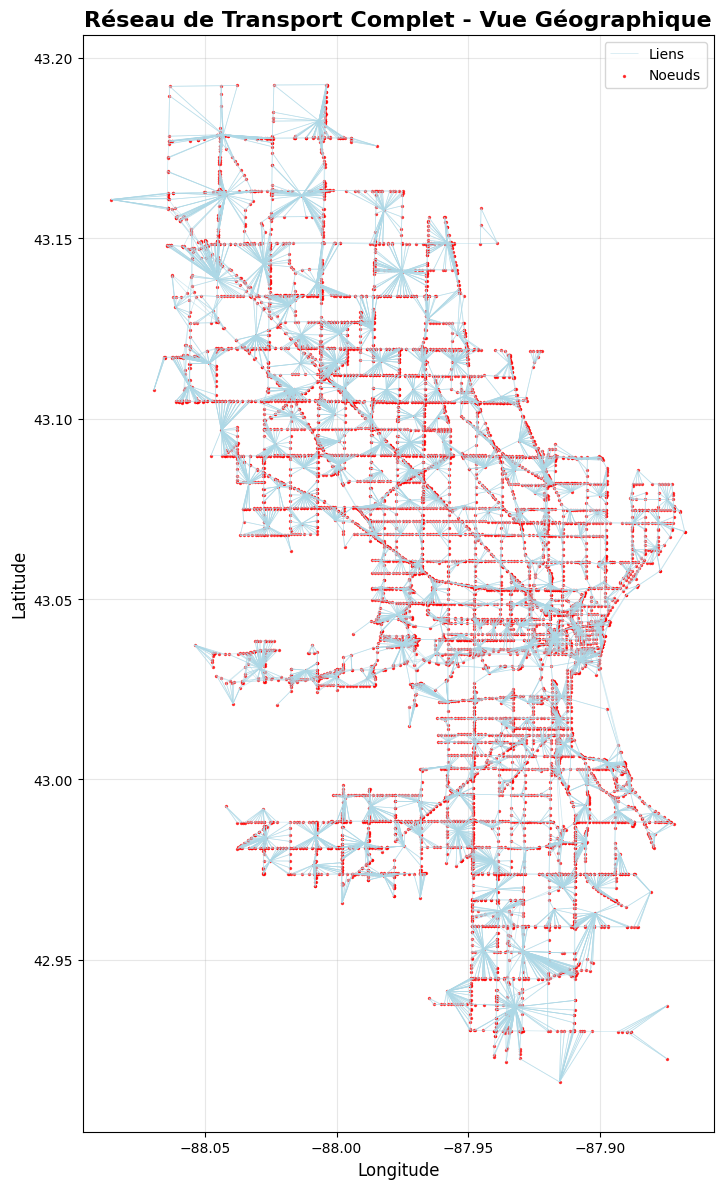

✓ Carte du réseau affichée: 8,521 noeuds, 30,747 liens


In [13]:
fig, ax = plt.subplots(figsize=(15, 12))

# Dessiner les liens
links_gdf.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.6, label='Liens')

# Dessiner les noeuds
nodes_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.7, label='Noeuds')

plt.title('Réseau de Transport Complet - Vue Géographique', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Carte du réseau affichée: {len(nodes_gdf):,} noeuds, {len(links_gdf):,} liens")

### 4.2 Échantillon du réseau pour une vue détaillée

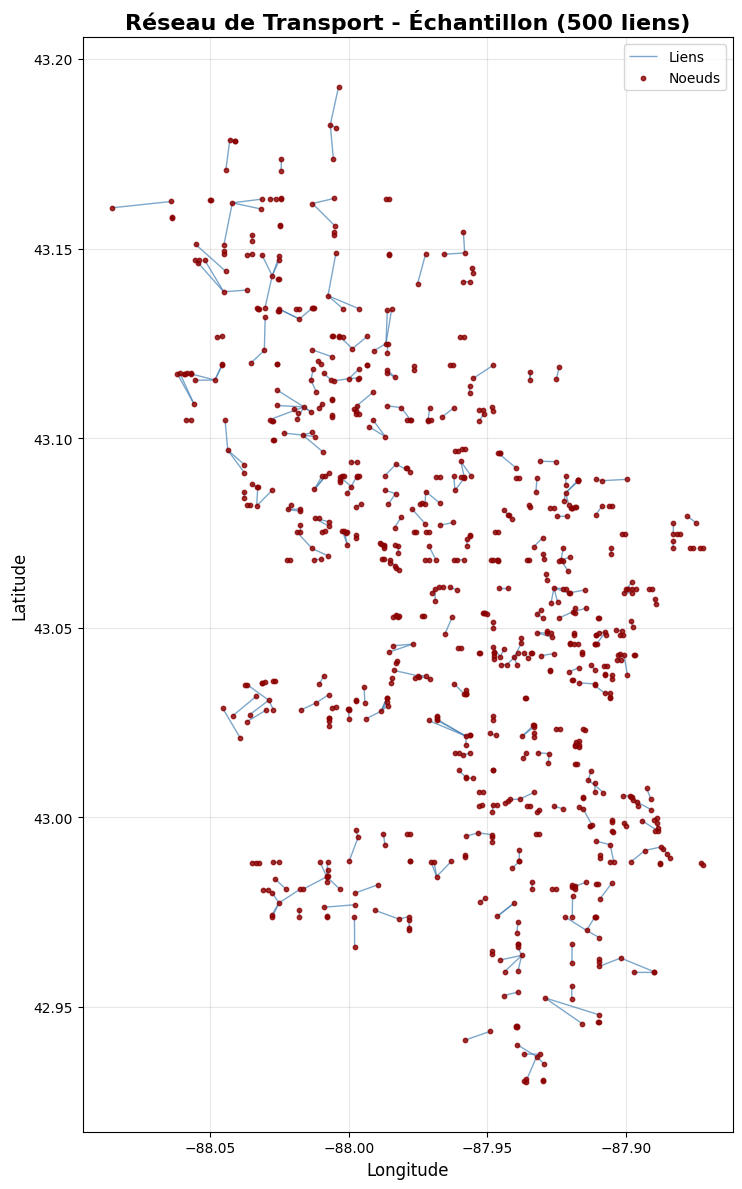

In [14]:
# Prendre un échantillon de liens pour une meilleure lisibilité
sample_size = 500
links_sample = links_gdf.sample(n=min(sample_size, len(links_gdf)), random_state=42)

# Identifier les noeuds connectés à ces liens
sample_node_ids = set(links_sample['from_node_id'].tolist() + links_sample['to_node_id'].tolist())
nodes_sample = nodes_gdf[nodes_gdf['node_id'].isin(sample_node_ids)]

fig, ax = plt.subplots(figsize=(15, 12))

# Dessiner l'échantillon
links_sample.plot(ax=ax, color='steelblue', linewidth=1, alpha=0.7, label='Liens')
nodes_sample.plot(ax=ax, color='darkred', markersize=10, alpha=0.8, label='Noeuds', zorder=5)

plt.title(f'Réseau de Transport - Échantillon ({sample_size} liens)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 Visualisation de la centralité des noeuds

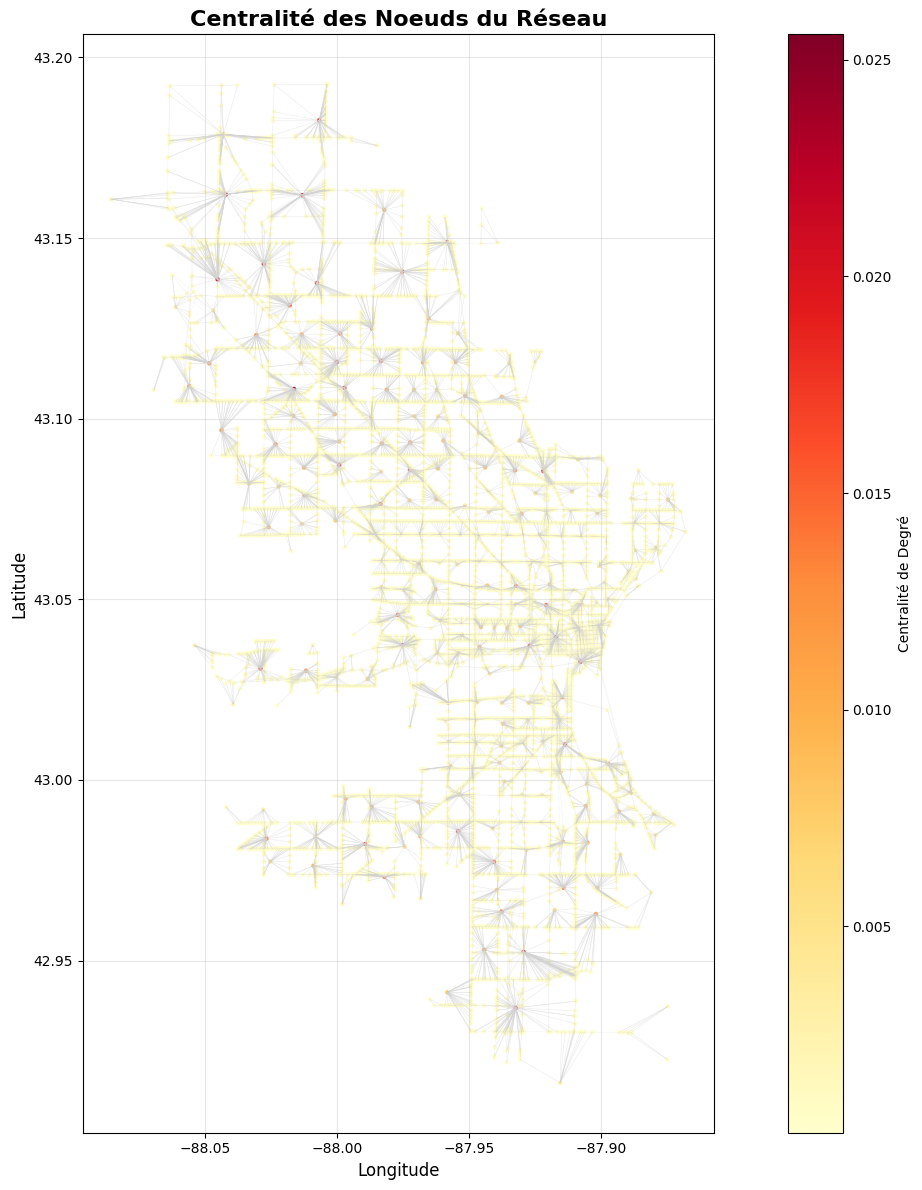

In [15]:
fig, ax = plt.subplots(figsize=(15, 12))

# Liens en arrière-plan
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.3, alpha=0.3)

# Noeuds colorés par centralité
nodes_gdf.plot(
    ax=ax,
    column='degree_centrality',
    cmap='YlOrRd',
    markersize=5,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': 'Centralité de Degré', 'orientation': 'vertical'}
)

plt.title('Centralité des Noeuds du Réseau', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Partie 5: Analyse de la Demande

### 5.1 Distribution de la demande

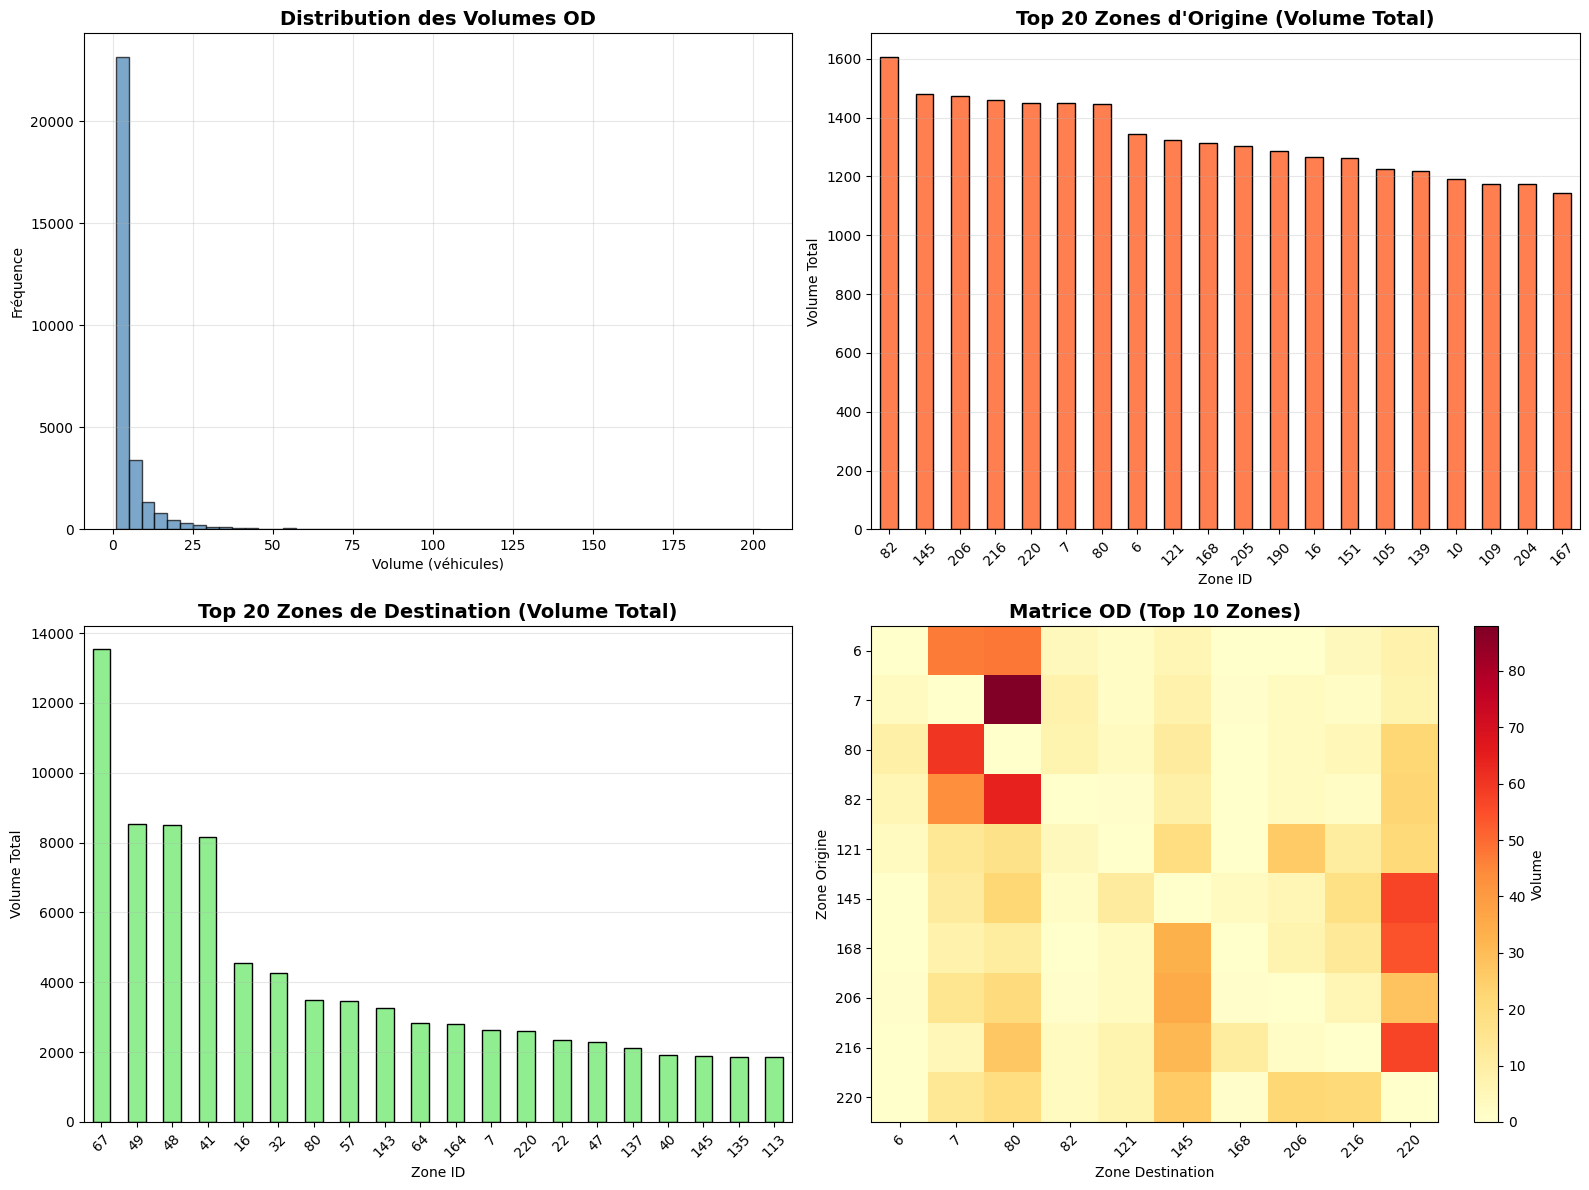

✓ Visualisations de la demande créées


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme des volumes
axes[0, 0].hist(demand_df['volume'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution des Volumes OD', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Volume (véhicules)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].grid(True, alpha=0.3)

# Demande par zone d'origine
demand_by_origin = demand_df.groupby('o_zone_id')['volume'].sum().sort_values(ascending=False).head(20)
demand_by_origin.plot(kind='bar', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_title('Top 20 Zones d\'Origine (Volume Total)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Zone ID')
axes[0, 1].set_ylabel('Volume Total')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Demande par zone de destination
demand_by_dest = demand_df.groupby('d_zone_id')['volume'].sum().sort_values(ascending=False).head(20)
demand_by_dest.plot(kind='bar', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Top 20 Zones de Destination (Volume Total)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Zone ID')
axes[1, 0].set_ylabel('Volume Total')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Matrice OD (top zones)
top_zones = demand_by_origin.head(10).index.tolist()
od_matrix_sample = demand_df[
    (demand_df['o_zone_id'].isin(top_zones)) & 
    (demand_df['d_zone_id'].isin(top_zones))
].pivot_table(index='o_zone_id', columns='d_zone_id', values='volume', fill_value=0)

im = axes[1, 1].imshow(od_matrix_sample, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Matrice OD (Top 10 Zones)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Zone Destination')
axes[1, 1].set_ylabel('Zone Origine')
axes[1, 1].set_xticks(range(len(od_matrix_sample.columns)))
axes[1, 1].set_yticks(range(len(od_matrix_sample.index)))
axes[1, 1].set_xticklabels(od_matrix_sample.columns, rotation=45)
axes[1, 1].set_yticklabels(od_matrix_sample.index)
plt.colorbar(im, ax=axes[1, 1], label='Volume')

plt.tight_layout()
plt.show()

print("✓ Visualisations de la demande créées")

### 5.2 Cartes des zones d'origine et de destination

C:\Users\maxde\AppData\Local\Temp\ipykernel_11144\936521502.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


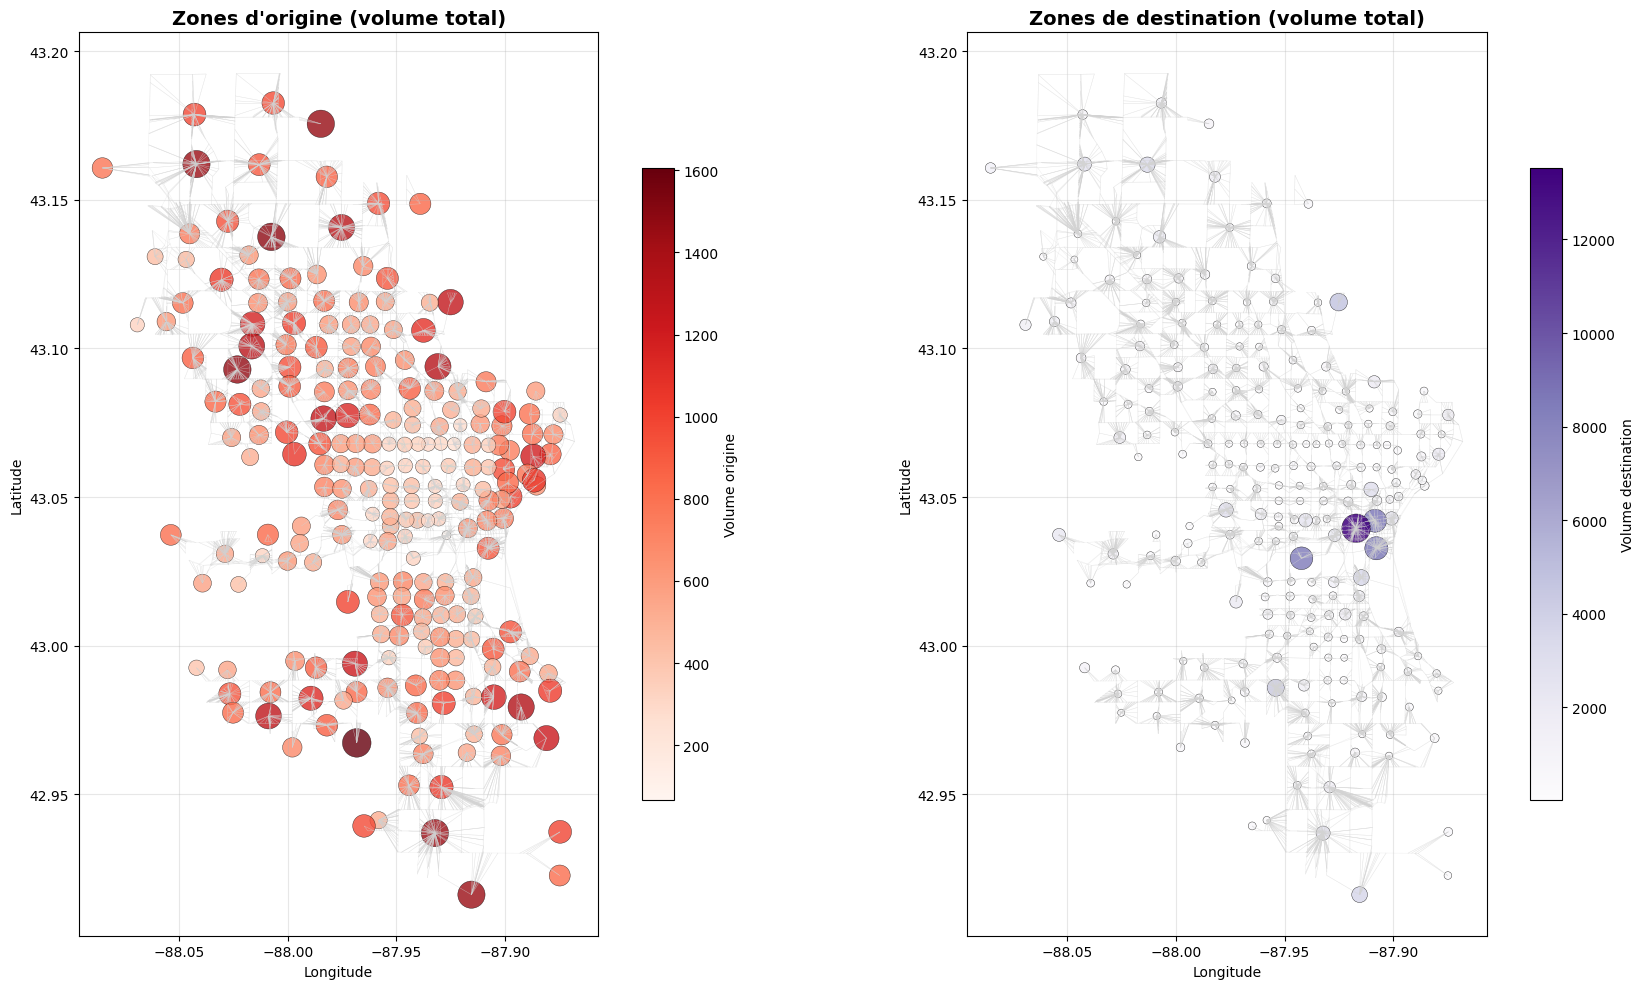

✓ Cartes des zones d'origine et de destination générées


In [29]:
# Calcul des volumes par zone d'origine et destination
origin_volume = demand_df.groupby('o_zone_id')['volume'].sum().rename('origin_volume')
destination_volume = demand_df.groupby('d_zone_id')['volume'].sum().rename('destination_volume')

# Créer des points représentatifs de zone à partir des noeuds (centroïde des noeuds de la zone)
zone_points = (
    nodes_gdf.dropna(subset=['zone_id'])
    .groupby('zone_id')['geometry_obj']
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
    .rename(columns={'geometry_obj': 'geometry'})
)
zone_points_gdf = gpd.GeoDataFrame(zone_points, geometry='geometry', crs=nodes_gdf.crs)

# Joindre les volumes
zone_points_gdf = zone_points_gdf.merge(origin_volume, left_on='zone_id', right_index=True, how='left')
zone_points_gdf = zone_points_gdf.merge(destination_volume, left_on='zone_id', right_index=True, how='left')
zone_points_gdf[['origin_volume', 'destination_volume']] = zone_points_gdf[['origin_volume', 'destination_volume']].fillna(0)

# Tailles de marqueurs proportionnelles (racine pour limiter les extrêmes)
max_origin = max(1, zone_points_gdf['origin_volume'].max())
max_dest = max(1, zone_points_gdf['destination_volume'].max())
zone_points_gdf['origin_size'] = 25 + 400 * zone_points_gdf['origin_volume'] / max_origin
zone_points_gdf['dest_size'] = 25 + 400 * zone_points_gdf['destination_volume'] / max_dest

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Carte des origines
links_gdf.plot(ax=axes[0], color='lightgray', linewidth=0.3, alpha=0.4)
zone_points_gdf.plot(
    ax=axes[0],
    column='origin_volume',
    cmap='Reds',
    markersize=zone_points_gdf['origin_size'],
    alpha=0.8,
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'label': 'Volume origine', 'shrink': 0.7}
)
axes[0].set_title("Zones d'origine (volume total)", fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True, alpha=0.3)

# Carte des destinations
links_gdf.plot(ax=axes[1], color='lightgray', linewidth=0.3, alpha=0.4)
zone_points_gdf.plot(
    ax=axes[1],
    column='destination_volume',
    cmap='Purples',  # palette plus foncée pour se détacher du fond
    markersize=zone_points_gdf['dest_size'],
    alpha=0.85,
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'label': 'Volume destination', 'shrink': 0.7}
)
axes[1].set_title('Zones de destination (volume total)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Cartes des zones d'origine et de destination générées")

---
## Partie 6: Analyse de Performance du Réseau

### 6.1 Fusion des données de performance avec les liens

In [17]:
# Fusionner link_performance avec links_gdf
links_with_perf = links_gdf.merge(link_perf_df, on='link_id', how='left')

# Calculer le ratio V/C (Volume/Capacité)
links_with_perf['vc_ratio'] = links_with_perf['volume'] / links_with_perf['capacity']
links_with_perf['vc_ratio'] = links_with_perf['vc_ratio'].fillna(0)

print("✓ Données de performance fusionnées avec les liens")
print(f"\nStatistiques du ratio V/C:")
print(f"  Moyenne: {links_with_perf['vc_ratio'].mean():.3f}")
print(f"  Médiane: {links_with_perf['vc_ratio'].median():.3f}")
print(f"  Max:     {links_with_perf['vc_ratio'].max():.3f}")
print(f"  Liens saturés (V/C > 1.0): {(links_with_perf['vc_ratio'] > 1.0).sum():,}")

✓ Données de performance fusionnées avec les liens

Statistiques du ratio V/C:
  Moyenne: 0.093
  Médiane: 0.000
  Max:     11.026
  Liens saturés (V/C > 1.0): 716


### 6.2 Catégorisation des niveaux de congestion

In [18]:
# Créer des catégories de congestion
def categorize_congestion(vc_ratio):
    if vc_ratio < 0.5:
        return 'Fluide'
    elif vc_ratio < 0.8:
        return 'Modéré'
    elif vc_ratio < 1.0:
        return 'Chargé'
    else:
        return 'Saturé'

links_with_perf['congestion_level'] = links_with_perf['vc_ratio'].apply(categorize_congestion)

# Compter les liens par niveau
congestion_counts = links_with_perf['congestion_level'].value_counts()
print("=" * 80)
print("RÉPARTITION DES NIVEAUX DE CONGESTION")
print("=" * 80)
print(congestion_counts.to_string())
print(f"\nTotal: {congestion_counts.sum():,} liens")

RÉPARTITION DES NIVEAUX DE CONGESTION
congestion_level
Fluide    29552
Saturé      719
Modéré      326
Chargé      150

Total: 30,747 liens


### 6.3 Visualisation de la congestion

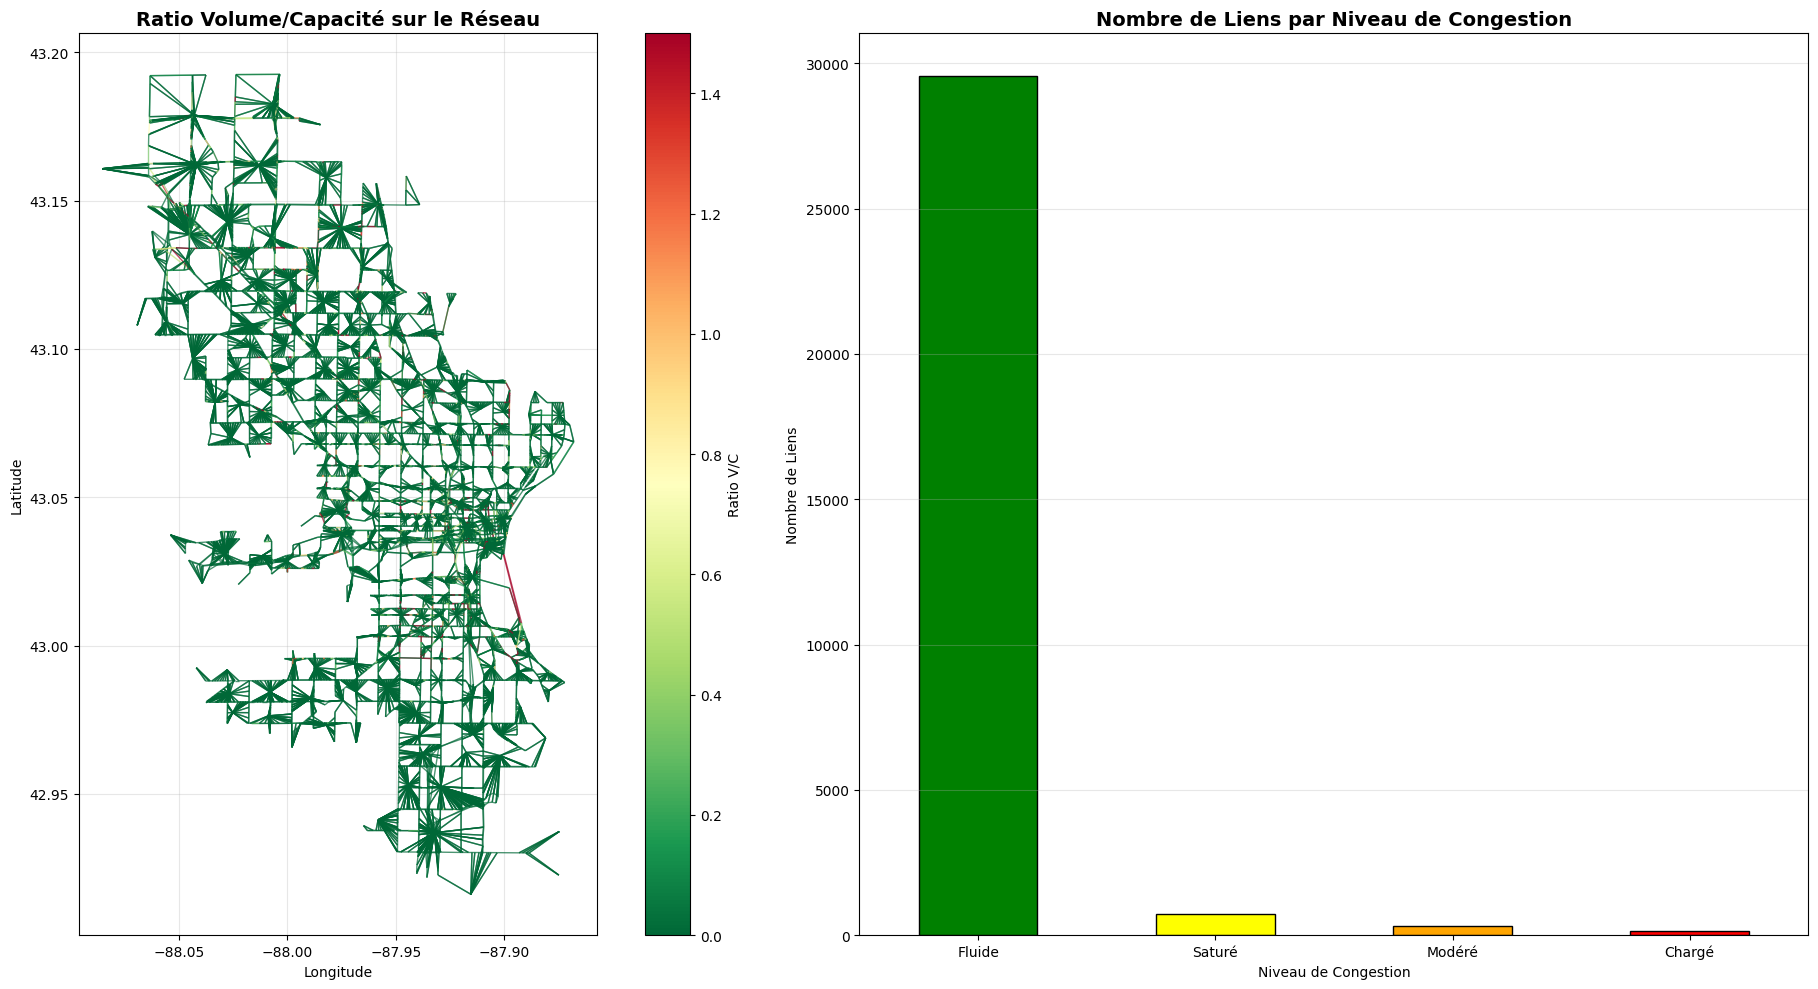

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Carte de chaleur V/C ratio
links_with_perf.plot(
    ax=axes[0],
    column='vc_ratio',
    cmap='RdYlGn_r',
    linewidth=1,
    alpha=0.7,
    legend=True,
    vmin=0,
    vmax=1.5,
    legend_kwds={'label': 'Ratio V/C', 'orientation': 'vertical'}
)
axes[0].set_title('Ratio Volume/Capacité sur le Réseau', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True, alpha=0.3)

# Graphique en barres des niveaux de congestion
congestion_counts.plot(kind='bar', ax=axes[1], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
axes[1].set_title('Nombre de Liens par Niveau de Congestion', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Niveau de Congestion')
axes[1].set_ylabel('Nombre de Liens')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 6.4 Analyse des délais

In [20]:
# Statistiques sur les délais
total_delay = links_with_perf['delay'].sum()
total_travel_time = links_with_perf['travel_time'].sum()
total_vht = links_with_perf['VHT'].sum()
total_vmt = links_with_perf['VMT'].sum()

print("=" * 80)
print("MÉTRIQUES DE PERFORMANCE DU RÉSEAU")
print("=" * 80)
print(f"Délai total:                {total_delay:,.0f} heures")
print(f"Temps de trajet total:      {total_travel_time:,.0f} heures")
print(f"VHT (Vehicle-Hours):        {total_vht:,.0f} heures")
print(f"VMT (Vehicle-Miles):        {total_vmt:,.0f} miles")
print(f"\nVitesse moyenne réseau:     {(total_vmt / total_vht) if total_vht > 0 else 0:.2f} mph")
print(f"Délai moyen par lien:       {links_with_perf['delay'].mean():.4f} heures")

KeyError: 'delay'

---
## Partie 7: Analyse d'Affectation de Routes

### 7.1 Statistiques des routes

In [21]:
print("=" * 80)
print("STATISTIQUES DES ROUTES")
print("=" * 80)
print(f"Nombre total de routes:     {len(route_assign_df):,}")
print(f"\nDistance moyenne:           {route_assign_df['distance_mile'].mean():.2f} miles")
print(f"Distance médiane:           {route_assign_df['distance_mile'].median():.2f} miles")
print(f"Distance max:               {route_assign_df['distance_mile'].max():.2f} miles")
print(f"\nTemps moyen:                {route_assign_df['total_travel_time'].mean():.2f} minutes")
print(f"Temps médian:               {route_assign_df['total_travel_time'].median():.2f} minutes")
print(f"Temps max:                  {route_assign_df['total_travel_time'].max():.2f} minutes")
print(f"\nVolume total routes:        {route_assign_df['volume'].sum():,.0f}")

STATISTIQUES DES ROUTES
Nombre total de routes:     29,031

Distance moyenne:           5.77 miles
Distance médiane:           5.23 miles
Distance max:               20.86 miles

Temps moyen:                11.78 minutes
Temps médian:               9.79 minutes
Temps max:                  66.06 minutes

Volume total routes:        156,930


### 7.2 Visualisation des distributions de routes

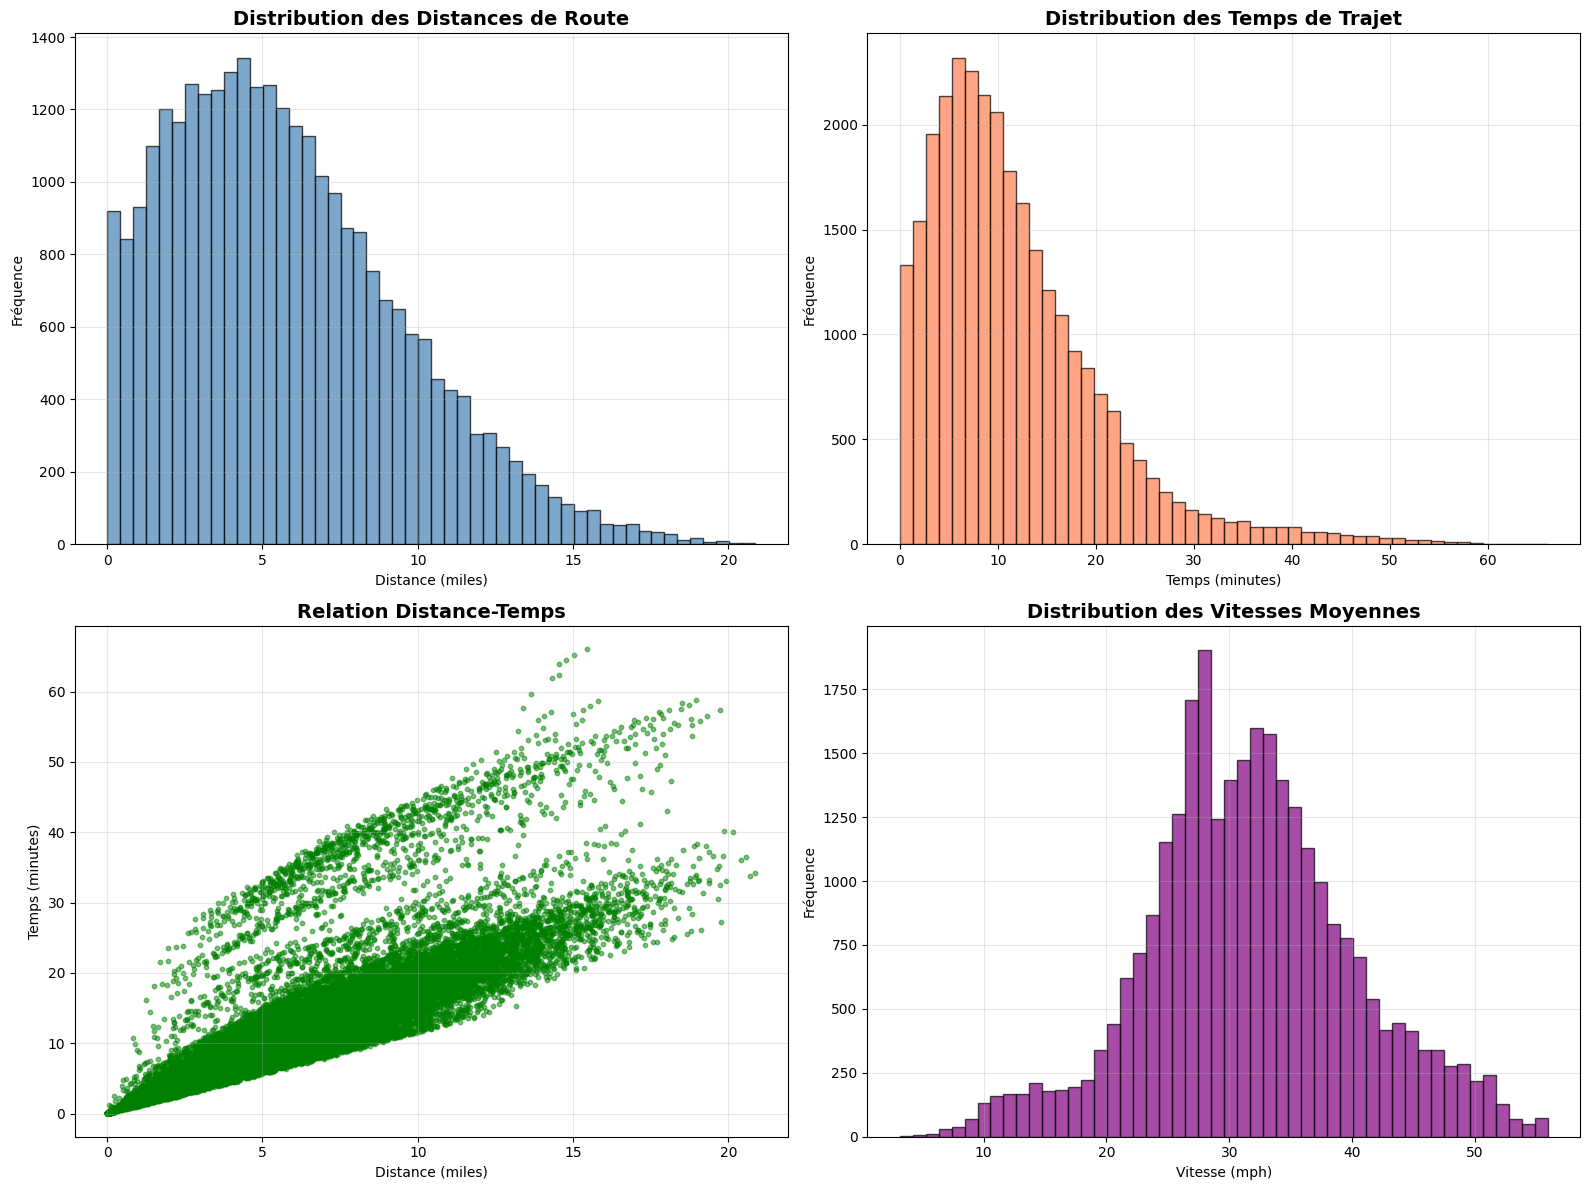

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution des distances
axes[0, 0].hist(route_assign_df['distance_mile'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution des Distances de Route', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Distance (miles)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].grid(True, alpha=0.3)

# Distribution des temps de trajet
axes[0, 1].hist(route_assign_df['total_travel_time'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution des Temps de Trajet', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Temps (minutes)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].grid(True, alpha=0.3)

# Relation distance-temps
axes[1, 0].scatter(
    route_assign_df['distance_mile'],
    route_assign_df['total_travel_time'],
    alpha=0.5,
    s=10,
    color='green'
)
axes[1, 0].set_title('Relation Distance-Temps', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Distance (miles)')
axes[1, 0].set_ylabel('Temps (minutes)')
axes[1, 0].grid(True, alpha=0.3)

# Vitesse moyenne par route
route_assign_df['avg_speed'] = (route_assign_df['distance_mile'] / route_assign_df['total_travel_time']) * 60
axes[1, 1].hist(route_assign_df['avg_speed'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution des Vitesses Moyennes', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Vitesse (mph)')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Partie 8: KPIs et Dashboard Final

### 8.1 Calcul des KPIs principaux

In [23]:
# KPIs du réseau
kpis = {
    'Nombre de noeuds': G.number_of_nodes(),
    'Nombre de liens': G.number_of_edges(),
    'Longueur totale réseau (miles)': links_gdf['length'].sum(),
    'VMT total': total_vmt,
    'VHT total': total_vht,
    'Vitesse moyenne réseau (mph)': total_vmt / total_vht if total_vht > 0 else 0,
    'Délai total (heures)': total_delay,
    'Ratio V/C moyen': links_with_perf['vc_ratio'].mean(),
    'Liens saturés (%)': (links_with_perf['vc_ratio'] > 1.0).sum() / len(links_with_perf) * 100,
    'Volume total demande': demand_df['volume'].sum(),
    'Nombre paires OD': len(demand_df),
    'Distance moyenne route (miles)': route_assign_df['distance_mile'].mean(),
    'Temps moyen route (min)': route_assign_df['total_travel_time'].mean(),
}

print("=" * 80)
print("KPIs PRINCIPAUX DU RÉSEAU")
print("=" * 80)
for key, value in kpis.items():
    if isinstance(value, float):
        print(f"{key:.<50} {value:>15,.2f}")
    else:
        print(f"{key:.<50} {value:>15,}")

NameError: name 'total_vmt' is not defined

### 8.2 Dashboard récapitulatif

KeyError: 'delay'

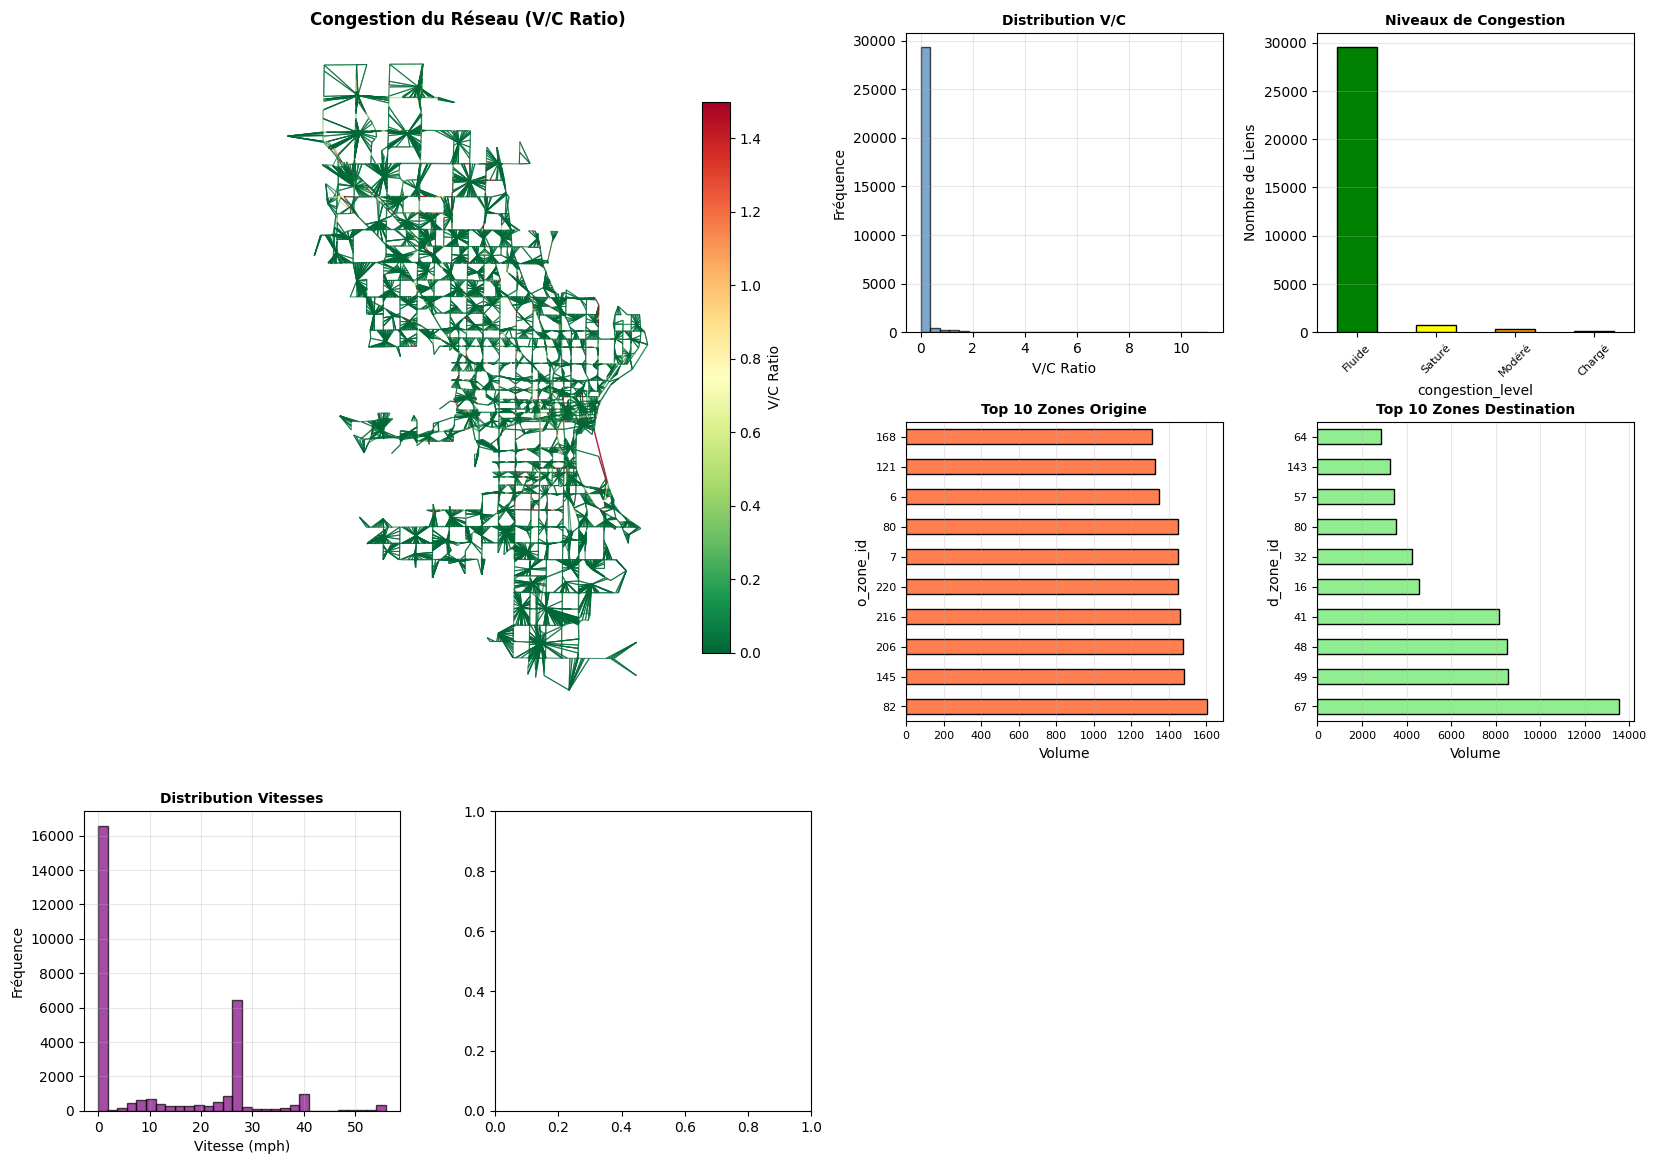

In [24]:
fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

# 1. Carte V/C ratio
ax1 = fig.add_subplot(gs[0:2, 0:2])
links_with_perf.plot(
    ax=ax1, column='vc_ratio', cmap='RdYlGn_r', linewidth=0.8, alpha=0.7,
    legend=True, vmin=0, vmax=1.5,
    legend_kwds={'label': 'V/C Ratio', 'shrink': 0.8}
)
ax1.set_title('Congestion du Réseau (V/C Ratio)', fontsize=12, fontweight='bold')
ax1.axis('off')

# 2. Distribution V/C
ax2 = fig.add_subplot(gs[0, 2])
ax2.hist(links_with_perf['vc_ratio'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution V/C', fontsize=10, fontweight='bold')
ax2.set_xlabel('V/C Ratio')
ax2.set_ylabel('Fréquence')
ax2.grid(True, alpha=0.3)

# 3. Niveaux de congestion
ax3 = fig.add_subplot(gs[0, 3])
congestion_counts.plot(kind='bar', ax=ax3, color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
ax3.set_title('Niveaux de Congestion', fontsize=10, fontweight='bold')
ax3.set_ylabel('Nombre de Liens')
ax3.tick_params(axis='x', rotation=45, labelsize=8)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Top zones origine
ax4 = fig.add_subplot(gs[1, 2])
demand_by_origin.head(10).plot(kind='barh', ax=ax4, color='coral', edgecolor='black')
ax4.set_title('Top 10 Zones Origine', fontsize=10, fontweight='bold')
ax4.set_xlabel('Volume')
ax4.tick_params(labelsize=8)
ax4.grid(True, alpha=0.3, axis='x')

# 5. Top zones destination
ax5 = fig.add_subplot(gs[1, 3])
demand_by_dest.head(10).plot(kind='barh', ax=ax5, color='lightgreen', edgecolor='black')
ax5.set_title('Top 10 Zones Destination', fontsize=10, fontweight='bold')
ax5.set_xlabel('Volume')
ax5.tick_params(labelsize=8)
ax5.grid(True, alpha=0.3, axis='x')

# 6. Distribution vitesses
ax6 = fig.add_subplot(gs[2, 0])
ax6.hist(links_with_perf['speed_mph'], bins=30, color='purple', edgecolor='black', alpha=0.7)
ax6.set_title('Distribution Vitesses', fontsize=10, fontweight='bold')
ax6.set_xlabel('Vitesse (mph)')
ax6.set_ylabel('Fréquence')
ax6.grid(True, alpha=0.3)

# 7. Distribution délais
ax7 = fig.add_subplot(gs[2, 1])
ax7.hist(links_with_perf['delay'], bins=30, color='orange', edgecolor='black', alpha=0.7)
ax7.set_title('Distribution Délais', fontsize=10, fontweight='bold')
ax7.set_xlabel('Délai (heures)')
ax7.set_ylabel('Fréquence')
ax7.grid(True, alpha=0.3)

# 8. KPIs texte
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')
kpi_text = "\n".join([f"{k}: {v:,.2f}" if isinstance(v, float) else f"{k}: {v:,}" 
                      for k, v in list(kpis.items())[:8]])
ax8.text(0.1, 0.5, kpi_text, fontsize=9, verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax8.set_title('KPIs Principaux', fontsize=10, fontweight='bold')

plt.suptitle('Dashboard Récapitulatif du Réseau DOTNET', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n" + "=" * 80)
print("ANALYSE COMPLÈTE TERMINÉE")
print("=" * 80)

---
## Conclusion

Ce notebook a couvert:
1. ✓ Chargement et exploration des données GMNS
2. ✓ Conversion en GeoDataFrames pour l'analyse spatiale
3. ✓ Création d'un graphe NetworkX dirigé
4. ✓ Visualisation géographique du réseau
5. ✓ Analyse de la demande (matrices OD)
6. ✓ Analyse de performance (V/C ratio, congestion, délais)
7. ✓ Analyse d'affectation de routes
8. ✓ Calcul de KPIs et création d'un dashboard

### Questions de réflexion:
- Quels sont les liens les plus congestionés? Où sont-ils situés?
- Comment la demande est-elle distribuée géographiquement?
- Quelles zones génèrent le plus de trafic?
- Quelle est la performance globale du réseau?
- Quels seraient les axes prioritaires d'amélioration?